## Семинар 5: "Улучшение сходимости нейросетей"

ФИО:

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
%matplotlib inline

На этом семинаре мы попробуем улучшить результаты, полученные на предыдущем занятии
Для этого нам понадобятся следующие вещи:
* Dropout
* Batch Normalization
* Инициализация весов

### Часть 1: Инициализация весов

На лекции доказывалось, что при инициализации He и Glorot дисперсия активаций градиентов в каждом слое будут примерно равны. Давайте проверим это. 

In [ ]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [ ]:
images_train, labels_train = next(iter(train_loader))

In [ ]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    pass

In [ ]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

<i> 1.1 </i> Инициализируйте полносвязную сеть нормальным шумом N(0, 0.1) с архитектурой 784 -> 500 x (10 раз) -> 10. В качестве активации возьмите tanh

In [ ]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=mean, std=std)

def init_xavier(layer, border):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.uniform_(-border, border)

def init_he(layer, mean=0, std=1):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=mean, std=np.sqrt(std))

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

    
# пример:
layers = []
layer_first = nn.Linear(28*28, 500)
init_layer(layer_first, 0, 0.1)
layer_first.register_backward_hook(backward_hook)
layer_first.register_forward_hook(forward_hook)
layers.append(layer_first)
layers.append(torch.nn.Tanh())
for _ in range(10):
    layer = nn.Linear(500, 500)
    init_layer(layer, 0, 0.1)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    layers.append(layer)
    layers.append(torch.nn.Tanh())

layer_last = nn.Linear(500, 10)
init_layer(layer_last, 0, 0.1)
layer_last.register_forward_hook(forward_hook)
layer_last.register_backward_hook(backward_hook)
layers.append(layer_last)

<i>1.2 Пропустите батч изображений через нейронную сеть и вычислите дисперсию активаций. Затем вычислите градиент и получите дисперсию градиентов. Сравните эти значения между собой для разных слоев.</i>

In [ ]:
network = nn.Sequential(*layers)

#пример:
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
print()
loss.backward()

<i>1.3 Повторите эксперимент для инициализаций He и Xavier (формулы есть в лекции).</i>

In [ ]:
layers = []
layer_first = nn.Linear(28*28, 500)
init_xavier(layer_first, np.sqrt(6/(28*28+500)))
layer_first.register_forward_hook(forward_hook)
layer_first.register_backward_hook(backward_hook)
layers.append(layer_first)
layers.append(torch.nn.Tanh())
for _ in range(10):
    layer = nn.Linear(500, 500)
    init_xavier(layer, np.sqrt(6/1000))
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    layers.append(layer)
    layers.append(torch.nn.Tanh())

layer_last = nn.Linear(500, 10)
init_xavier(layer_last, np.sqrt(6/510))
layer_last.register_forward_hook(forward_hook)
layer_last.register_backward_hook(backward_hook)
layers.append(layer_last)

In [ ]:
network = nn.Sequential(*layers)

#пример:
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss = loss_fn(activations, y)
print()
loss.backward()

In [ ]:
layers = []
layer_first = nn.Linear(28*28, 500)
init_he(layer_first, std=2/(28*28))
layer_first.register_forward_hook(forward_hook)
layer_first.register_backward_hook(backward_hook)
layers.append(layer_first)
layers.append(torch.nn.ReLU())
for _ in range(10):
    layer = nn.Linear(500, 500)
    init_he(layer, std=2/500)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    layers.append(layer)
    layers.append(torch.nn.ReLU())

layer_last = nn.Linear(500, 10)
init_he(layer_last, std=2/500)
layer_last.register_forward_hook(forward_hook)
layer_last.register_backward_hook(backward_hook)
layers.append(layer_last)

In [ ]:
network = nn.Sequential(*layers)

#пример:
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss = loss_fn(activations, y)
print()
loss.backward()

<i> 1.4 Сделайте выводы по первой части </i>

### Часть 2: Dropout

Другим полезным слоем является Dropout. В нем с вероятностью 1-p зануляется выход каждого нейрона. Этот слой уже реализован в pyTorch, поэтому вновь реализовывать его не интересно. Давайте реализуем DropConnect — аналог Dropout. В нем с вероятностью 1-p зануляется каждый вес слоя.

<i> 2.1 Реализуйте линейный слой с DropConnect </i>

In [ ]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5):
        super(DropConnect, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.p = p
        self.input_dim = input_dim
        self.output_dim = output_dim

    def forward(self, x):
        if self.training:
            mask = torch.bernoulli(torch.Tensor(self.output_dim, self.input_dim), 1-self.p)
        else:
            mask = torch.ones_like(self.linear.weight)
        mask.requires_grad = False
        mask = mask.data
        a = self.linear.weight * mask * (1-self.p)
        output = F.linear(x, a, self.linear.bias)
        return output

<i> 
2.2 Сравните графики обучения нейроных сетей:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Dropout между всеми слоями 
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU DropConnect вместо всех линейных слоев
</i>

In [32]:
class TestNetwork(nn.Module):
    def __init__(self, final_part):
        super().__init__()
        
        channels = 1
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, 2, 3, padding=1),    
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(2, 4, 3, padding=1),            
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        
        #input_size = 7 * 7 * 4 = 196
        self.flatten = nn.Flatten()
        
        self.final_part = final_part
        
        self.log_softmax = nn.LogSoftmax(1)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.final_part(x)
        return self.log_softmax(x)

In [33]:
from train_utils import train

Epoch 9... (Train/Test) NLL: 0.047/0.059	Accuracy: 0.984/0.982


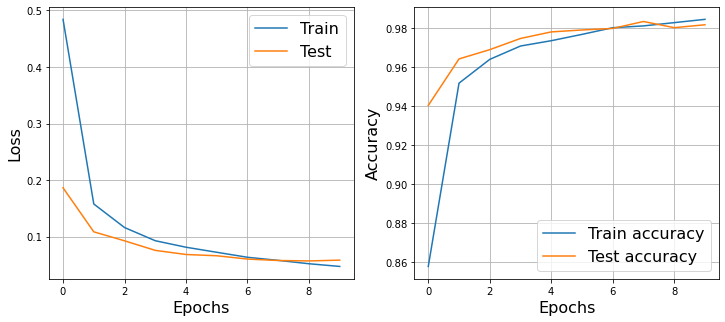

([0.4842344386808908,
  0.15789258117868957,
  0.11626761507139659,
  0.0929520649662706,
  0.08144286687352828,
  0.0725165486498587,
  0.06366864423543564,
  0.058202544715740025,
  0.05225432238408497,
  0.04747837868286793],
 [0.18651208356965945,
  0.10868690101594865,
  0.09278873750303365,
  0.07589384602217734,
  0.06860266256888833,
  0.0663609580855958,
  0.06049994745916581,
  0.0579885431046633,
  0.05721935583425898,
  0.058618153327533715],
 [0.8577314,
  0.9516758,
  0.9638693,
  0.97071564,
  0.97343636,
  0.9766791,
  0.98009396,
  0.98102677,
  0.9826981,
  0.98438054],
 [0.940269,
  0.964102,
  0.9688489,
  0.97458464,
  0.977947,
  0.9789359,
  0.979727,
  0.98328716,
  0.9801226,
  0.981606])

In [34]:
layers_simple = [
    torch.nn.Linear(196, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 128),
    nn.ReLU(),
    torch.nn.Linear(128, 10),
]
network_simple = TestNetwork(nn.Sequential(*layers_simple))
train(network_simple, train_loader, test_loader, 10, 0.001)

Epoch 9... (Train/Test) NLL: 0.133/0.072	Accuracy: 0.961/0.979


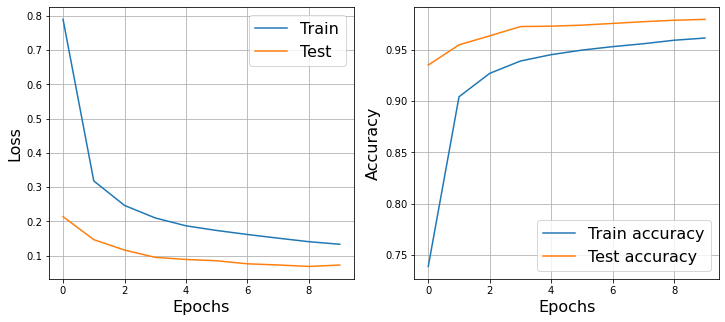

([0.7899158111195574,
  0.3180512743972258,
  0.24637856170821038,
  0.20984025682404098,
  0.18685923235566376,
  0.17324180082122145,
  0.16151856651692503,
  0.1507566750033705,
  0.1404593973073052,
  0.13297322922265098],
 [0.21364451690187938,
  0.14650585606128355,
  0.11600030034403258,
  0.09472746812278711,
  0.08853347990897638,
  0.08477193749026407,
  0.07591627186895171,
  0.0724718404441624,
  0.0682032981745993,
  0.07234944084871418],
 [0.73888373,
  0.9040956,
  0.92688346,
  0.9388826,
  0.9450848,
  0.9495103,
  0.952864,
  0.95570695,
  0.95910513,
  0.9612318],
 [0.9349288,
  0.9546084,
  0.9634098,
  0.972409,
  0.9728046,
  0.9737935,
  0.97547466,
  0.97715586,
  0.97854036,
  0.9794304])

In [35]:
layers1 = [
    torch.nn.Linear(196, 128),
    torch.nn.Dropout(0.5),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 128),
    torch.nn.Dropout(0.5),
    nn.ReLU(),
    torch.nn.Linear(128, 10),
]
network1 = TestNetwork(nn.Sequential(*layers1))
train(network1, train_loader, test_loader, 10, 0.001)

Epoch 9... (Train/Test) NLL: 0.126/0.193	Accuracy: 0.961/0.973


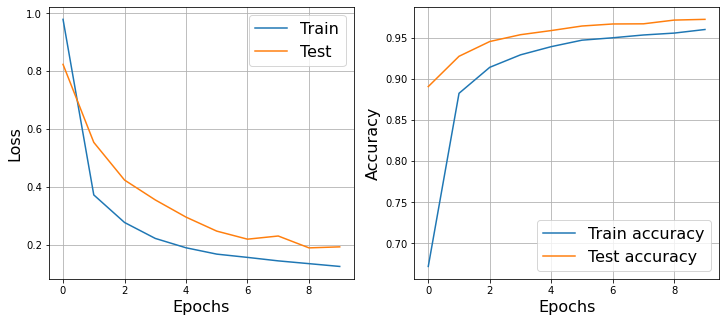

([0.9793340941227829,
  0.3727141965363326,
  0.2774995662796218,
  0.22239085890527474,
  0.1900711961741895,
  0.16813266460003376,
  0.1568423730176268,
  0.14482997858257435,
  0.13522431253592596,
  0.12556775218880634],
 [0.8237435536671288,
  0.5542913966552838,
  0.42410869594616224,
  0.3554570110488235,
  0.2960397619921325,
  0.24763747059468405,
  0.2198029120446117,
  0.23073632956358686,
  0.1897578731618005,
  0.1932484127958364],
 [0.67191947,
  0.88282365,
  0.9144845,
  0.92967635,
  0.9396655,
  0.94754463,
  0.95045424,
  0.95386904,
  0.95617336,
  0.96053773],
 [0.8910206,
  0.9279074,
  0.94590586,
  0.95421284,
  0.95925635,
  0.9647943,
  0.9672666,
  0.9674644,
  0.9720135,
  0.9729035])

In [36]:
layers_drop_connect = [
    DropConnect(196, 128),
    torch.nn.ReLU(),
    DropConnect(128, 128),
    nn.ReLU(),
    torch.nn.Linear(128, 10),
]
network_drop_connect = TestNetwork(nn.Sequential(*layers_drop_connect))
train(network_drop_connect, train_loader, test_loader, 10, 0.001)

В test-time стохастичность Dropout убирают и заменяют все веса на их ожидаемое значение: $\mathbb{E}w = pw + (1-p)0 = pw$.

<i> 2.3 Сделайте выводы по третьей части. </i>

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

<i> 3.1 Реализуйте Layer Normalization </i>

In [79]:
# полезные функции: .std(dim), .mean(dim)

class LayerNormalization(nn.Module):
    def __init__(self):
        self.gamma = torch.autograd.Variable(torch.tensor(1.0), requires_grad=True)
        self.betta = torch.autograd.Variable(torch.tensor(0.0), requires_grad=True)
        super().__init__()
    def forward(self, x):
        output = (x.transpose(1,0)-x.mean(dim=1))/x.std(dim=1) * self.gamma + self.betta
        return output.transpose(1, 0)

<i>
3.2 Сравните графики обучения нейроных сетей:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Batch normalization между всеми слоями
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Layer normalization между всеми слоями
</i>

Epoch 9... (Train/Test) NLL: 0.029/0.059	Accuracy: 0.990/0.981


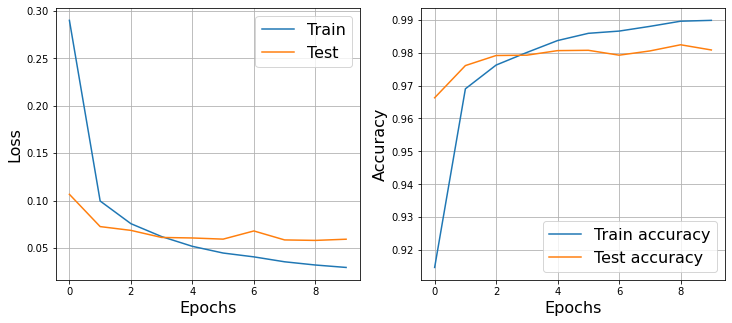

([0.289992975059158,
  0.09953003503413978,
  0.07564526912309467,
  0.06202841332075057,
  0.05175290719719171,
  0.04469056415117419,
  0.04064171714608921,
  0.03545742296476735,
  0.03206197694013479,
  0.029495165955874997],
 [0.10659019295361978,
  0.07256599169083033,
  0.06857321713166901,
  0.06111201749454382,
  0.060568847339836106,
  0.059339198661095736,
  0.06796317030616765,
  0.058502310518576184,
  0.058000232632378045,
  0.05925776026966168],
 [0.9146788,
  0.96899986,
  0.97622937,
  0.98006064,
  0.9836809,
  0.9858797,
  0.9865572,
  0.9879897,
  0.9895611,
  0.9898221],
 [0.9662777,
  0.976068,
  0.9791337,
  0.9792326,
  0.9806171,
  0.980716,
  0.9792326,
  0.9805182,
  0.98239714,
  0.9808149])

In [82]:
layers_normalization = [
    LayerNormalization(),
    torch.nn.Linear(196, 128),
    torch.nn.ReLU(),
    LayerNormalization(),
    torch.nn.Linear(128, 128),
    nn.ReLU(),
    nn.LayerNorm([128]),
    torch.nn.Linear(128, 10),
]
network_normalization = TestNetwork(nn.Sequential(*layers_normalization))
train(network_normalization, train_loader, test_loader, 10, 0.001)

<i> 3.3 Сделайте выводы по третьей части </i>

Нормализация это мощный инструмент, который позволяет уменьшить ошибку на тестовой выборке

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: